In [1]:
import os
import numpy as np
from tqdm import tqdm
import pandas as pd
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split
from tensorflow import keras

2024-06-07 09:31:37.943499: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-07 09:31:37.943635: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-07 09:31:38.112971: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Load the CSV file
csv_file_path = '/kaggle/input/rsna-bone-age/boneage-training-dataset.csv'
dataset_path = '/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset'
df = pd.read_csv(csv_file_path)

# Filter the dataset based on conditions
ra = []
for i in range(187):
    if i % 12 == 5 or i % 12 == 6 or i % 12 == 7:
        ra.append(i)

id_to_bone_age = {row['id']: row['boneage'] for _, row in df.iterrows()}

selected_ids = [int(file_name.split('.')[0]) for file_name in os.listdir(dataset_path) if file_name.split('.')[0].isdigit()]
filtered_ids = [id for id in selected_ids if id_to_bone_age[id] in ra]

image_paths = [os.path.join(dataset_path, f"{id}.png") for id in filtered_ids]
ages = [id_to_bone_age[id] // 12 for id in filtered_ids]

# Split the dataset into training and testing sets
X_train_paths, X_test_paths, y_train, y_test = train_test_split(
    image_paths, ages, test_size=0.2, random_state=42
)

In [3]:
id_to_bone_age = {row['id']: row['boneage'] for _, row in df.iterrows()}
image_paths = []
ages = []

for file_name in os.listdir(dataset_path):
    file_path = os.path.join(dataset_path, file_name)
    idf=file_name.split('.')[0]
    if(idf.isdigit()):
      if(id_to_bone_age[int(idf)] in ra ):

        image_paths.append(file_path)
        ages.append(id_to_bone_age[int(file_name.split('.')[0])]//12)

In [4]:
image_paths = np.array(image_paths)
ages = np.array(ages)
print(image_paths)
print(ages)
print(len(image_paths),len(ages))

['/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset/9273.png'
 '/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset/14127.png'
 '/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset/11396.png'
 ...
 '/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset/6995.png'
 '/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset/14760.png'
 '/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset/4225.png']
[12 14  4 ... 11 13 12]
2921 2921


In [5]:
unique_values, counts = np.unique(ages, return_counts=True)

# Display the value counts
for value, count in zip(unique_values, counts):
    print(f"{value}: {count} occurrences")

0: 2 occurrences
1: 29 occurrences
2: 39 occurrences
3: 90 occurrences
4: 101 occurrences
5: 44 occurrences
6: 56 occurrences
7: 51 occurrences
8: 51 occurrences
9: 116 occurrences
10: 204 occurrences
11: 536 occurrences
12: 681 occurrences
13: 685 occurrences
14: 98 occurrences
15: 138 occurrences


In [6]:
for value, count in zip(unique_values, counts):
    if count < 75:
        # Augment the data to reach 75 occurrences
        augmentation_factor = int(np.ceil(75 / count))
        indices = np.where(ages == value)[0]

        # Augment the data by replicating images
        augmented_paths = np.repeat(np.array(image_paths)[indices], augmentation_factor)
        augmented_ages = np.repeat(value, len(augmented_paths))

        # Update the dataset
        image_paths = np.concatenate([image_paths, augmented_paths])
        ages = np.concatenate([ages, augmented_ages])

# Split the augmented dataset into training and testing sets
X_train_paths, X_test_paths, y_train, y_test = train_test_split(
    image_paths, ages, test_size=0.2, random_state=42
)

In [7]:
unique_values, counts = np.unique(ages, return_counts=True)

# Display the value counts
for value, count in zip(unique_values, counts):
    print(f"{value}: {count} occurrences")

0: 78 occurrences
1: 116 occurrences
2: 117 occurrences
3: 90 occurrences
4: 101 occurrences
5: 132 occurrences
6: 168 occurrences
7: 153 occurrences
8: 153 occurrences
9: 116 occurrences
10: 204 occurrences
11: 536 occurrences
12: 681 occurrences
13: 685 occurrences
14: 98 occurrences
15: 138 occurrences


In [8]:
# Load and preprocess images
import cv2
from tensorflow.keras.preprocessing import image
def preprocess_images(image_paths, target_size=(224, 224)):
    images = []
    for path in tqdm(image_paths, desc='Loading and Preprocessing Images'):
        img = image.load_img(path, target_size=target_size)
        img = image.img_to_array(img)  # Convert PIL Image to NumPy array
        img = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        img = cv2.equalizeHist(img.astype('uint8'))
        img_array = np.expand_dims(img, axis=0)
        img_array = preprocess_input(img_array)
        images.append(img_array)
    return np.vstack(images)

X_train = preprocess_images(X_train_paths)
X_test = preprocess_images(X_test_paths)


Loading and Preprocessing Images: 100%|██████████| 714/714 [00:30<00:00, 23.15it/s]


In [9]:
from tensorflow.keras.models import Model
base_model = VGG16(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)

# Squeeze the singleton dimension
X_train_squeezed = np.squeeze(X_train)
X_test_squeezed = np.squeeze(X_test)

# Add a new dimension at the end representing the number of channels (3 for RGB)
X_train_with_channels = np.expand_dims(X_train_squeezed, axis=-1)
X_test_with_channels = np.expand_dims(X_test_squeezed, axis=-1)

# Repeat the channel dimension to have 3 channels
X_train_3_channels = np.repeat(X_train_with_channels, 3, axis=-1)
X_test_3_channels = np.repeat(X_test_with_channels, 3, axis=-1)

# Preprocess the input data
X_train_preprocessed = np.array([preprocess_input(img) for img in X_train_3_channels])
X_test_preprocessed = np.array([preprocess_input(img) for img in X_test_3_channels])

try:
    # Extract features for training set
    X_train_features = model.predict(X_train_preprocessed, batch_size=32, verbose=1)
    print(f"Shape of extracted features for training set: {X_train_features.shape}")

    # Extract features for testing set
    X_test_features = model.predict(X_test_preprocessed, batch_size=32, verbose=1)
    print(f"Shape of extracted features for testing set: {X_test_features.shape}")

except Exception as e:
    print(e)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

linear_model = LinearRegression()
linear_model.fit(X_train_features, y_train)

# Predict on the test set
y_pred_linear = linear_model.predict(X_test_features)

# Evaluate the linear regression model
mae_linear = mean_absolute_error(y_test, y_pred_linear)
print(f"Mean Absolute Error (Linear Regression) on Test Set: {mae_linear}")

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 18s 0us/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 827s 9s/step
Shape of extracted features for training set: (2852, 4096)
23/23 ━━━━━━━━━━━━━━━━━━━━ 202s 9s/step
Shape of extracted features for testing set: (714, 4096)
Mean Absolute Error (Linear Regression) on Test Set: 2.508246355030049


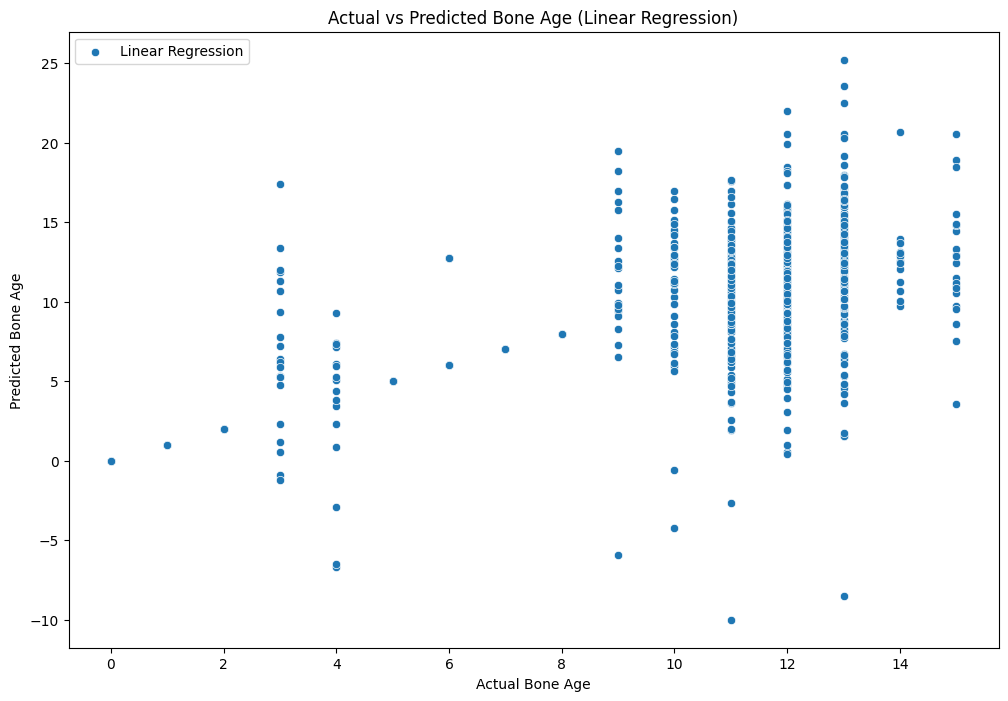

Mean Absolute Error (Decision Tree) on Test Set: 1.5532212885154062
Mean Absolute Error (Random Forest) on Test Set: 1.2870588235294116
Mean Absolute Error (SVM) on Test Set: 1.565460819231716


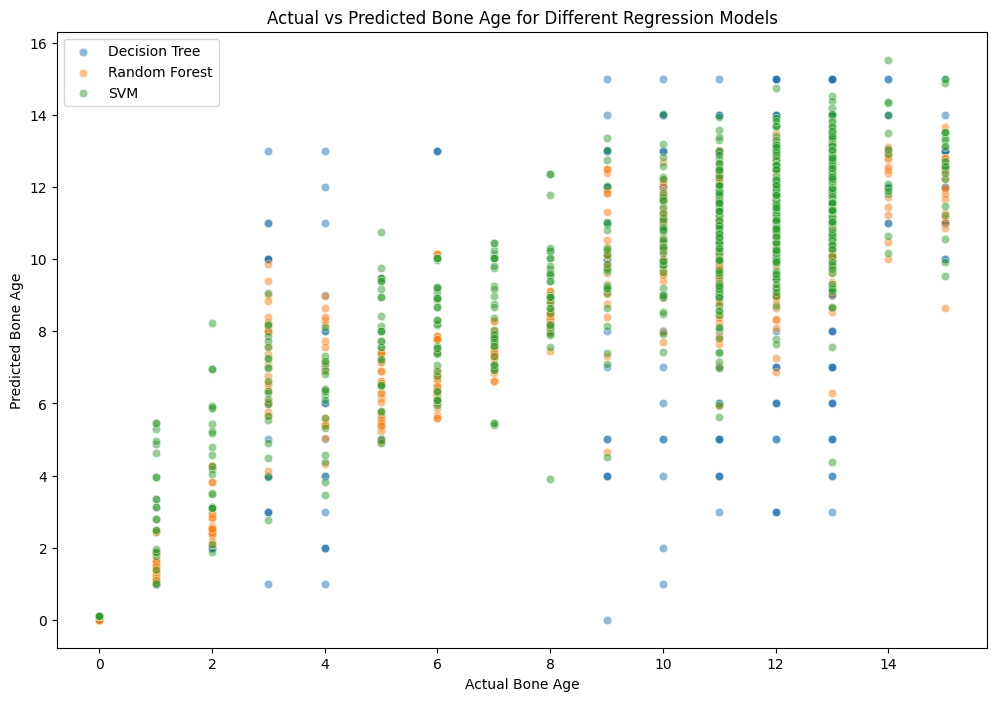

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot of actual vs predicted values for Linear Regression
plt.figure(figsize=(12, 8))
sns.scatterplot(x=y_test, y=y_pred_linear, label="Linear Regression")

plt.xlabel("Actual Bone Age")
plt.ylabel("Predicted Bone Age")
plt.title("Actual vs Predicted Bone Age (Linear Regression)")
plt.legend()
plt.show()

# Let's explore other regression models for comparison
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# Create and train Decision Tree model
decision_tree_model = DecisionTreeRegressor(random_state=42)
decision_tree_model.fit(X_train_features, y_train)

# Predict on the test set
y_pred_decision_tree = decision_tree_model.predict(X_test_features)

# Evaluate Decision Tree model
mae_decision_tree = mean_absolute_error(y_test, y_pred_decision_tree)
print(f"Mean Absolute Error (Decision Tree) on Test Set: {mae_decision_tree}")

# Create and train Random Forest model
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model.fit(X_train_features, y_train)

# Predict on the test set
y_pred_random_forest = random_forest_model.predict(X_test_features)

# Evaluate Random Forest model
mae_random_forest = mean_absolute_error(y_test, y_pred_random_forest)
print(f"Mean Absolute Error (Random Forest) on Test Set: {mae_random_forest}")

# Create and train SVM model
svm_model = SVR()
svm_model.fit(X_train_features, y_train)

# Predict on the test set
y_pred_svm = svm_model.predict(X_test_features)

# Evaluate SVM model
mae_svm = mean_absolute_error(y_test, y_pred_svm)
print(f"Mean Absolute Error (SVM) on Test Set: {mae_svm}")

# Scatter plot for Decision Tree, Random Forest, and SVM
plt.figure(figsize=(12, 8))
sns.scatterplot(x=y_test, y=y_pred_decision_tree, label="Decision Tree", alpha=0.5)
sns.scatterplot(x=y_test, y=y_pred_random_forest, label="Random Forest", alpha=0.5)
sns.scatterplot(x=y_test, y=y_pred_svm, label="SVM", alpha=0.5)

plt.xlabel("Actual Bone Age")
plt.ylabel("Predicted Bone Age")
plt.title("Actual vs Predicted Bone Age for Different Regression Models")
plt.legend()
plt.show()


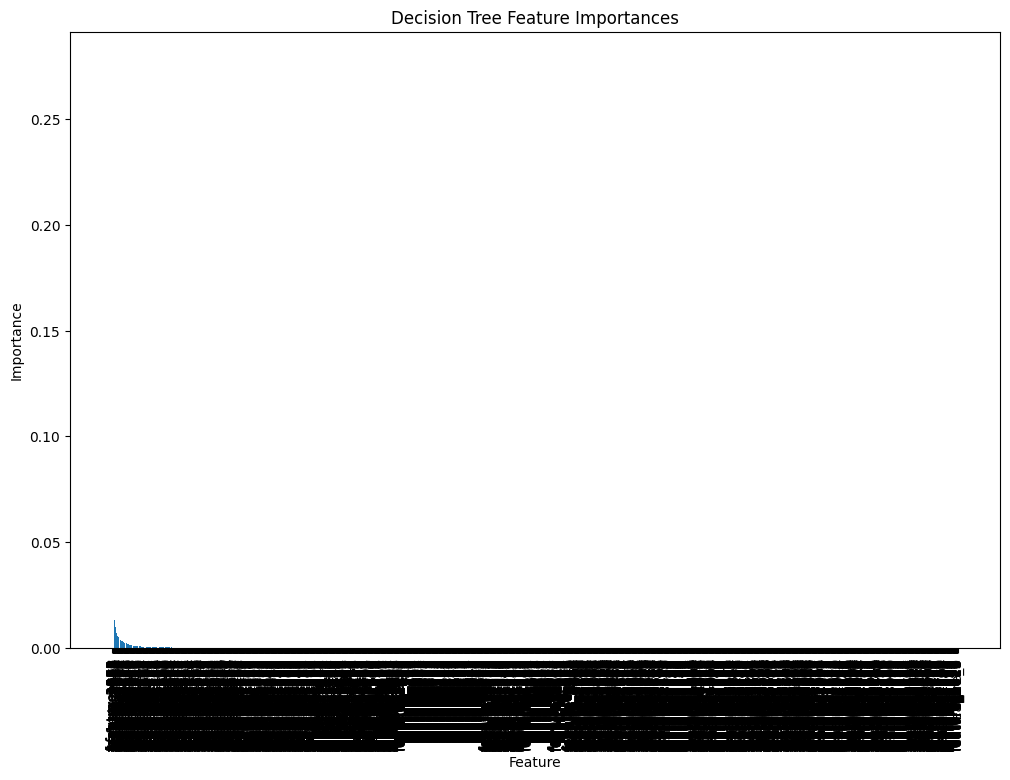

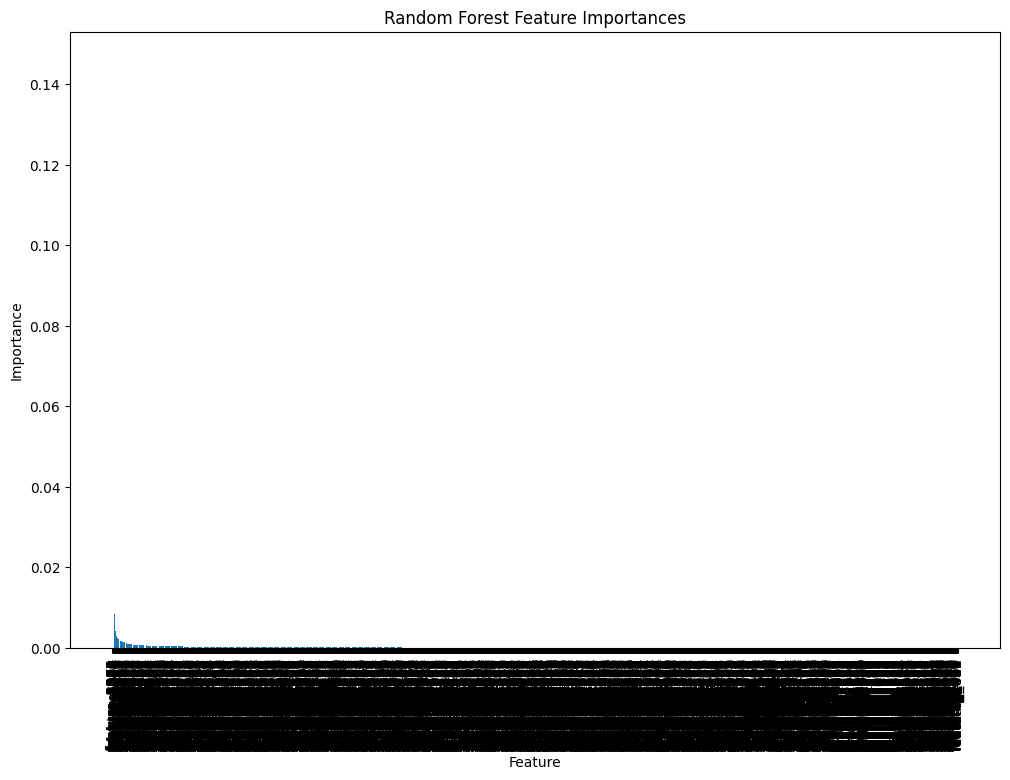

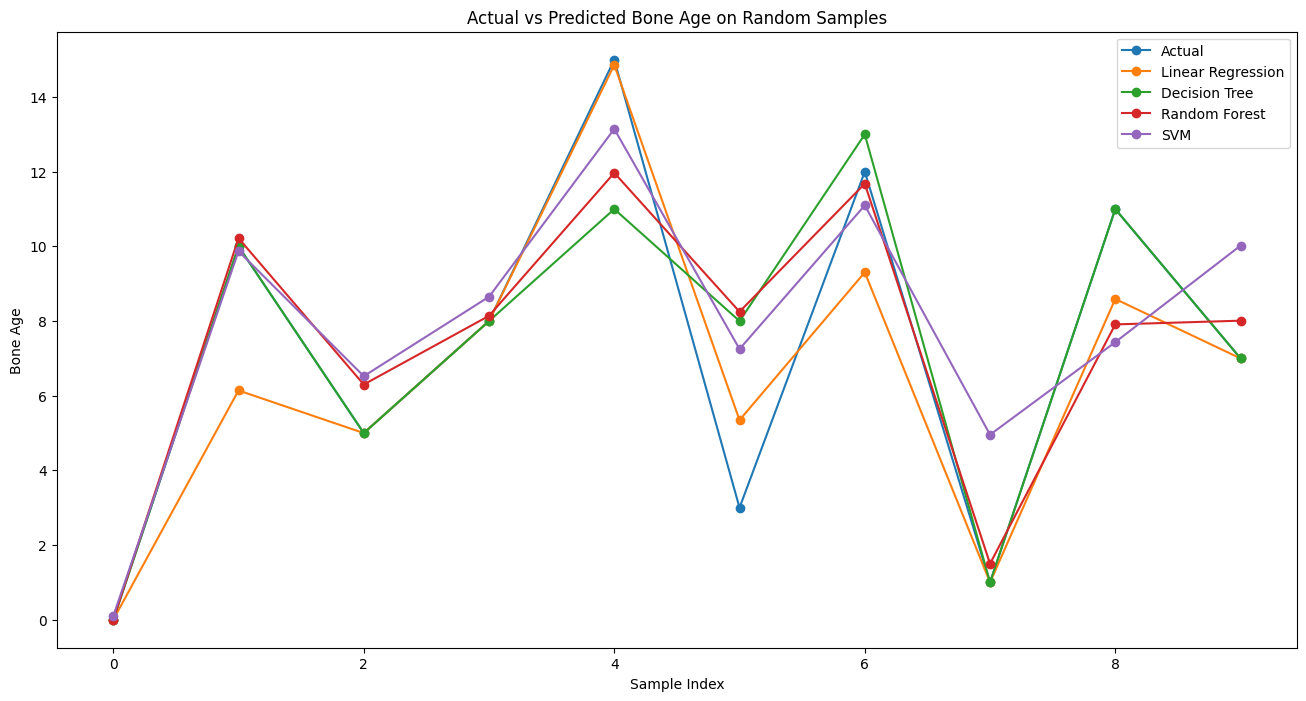

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

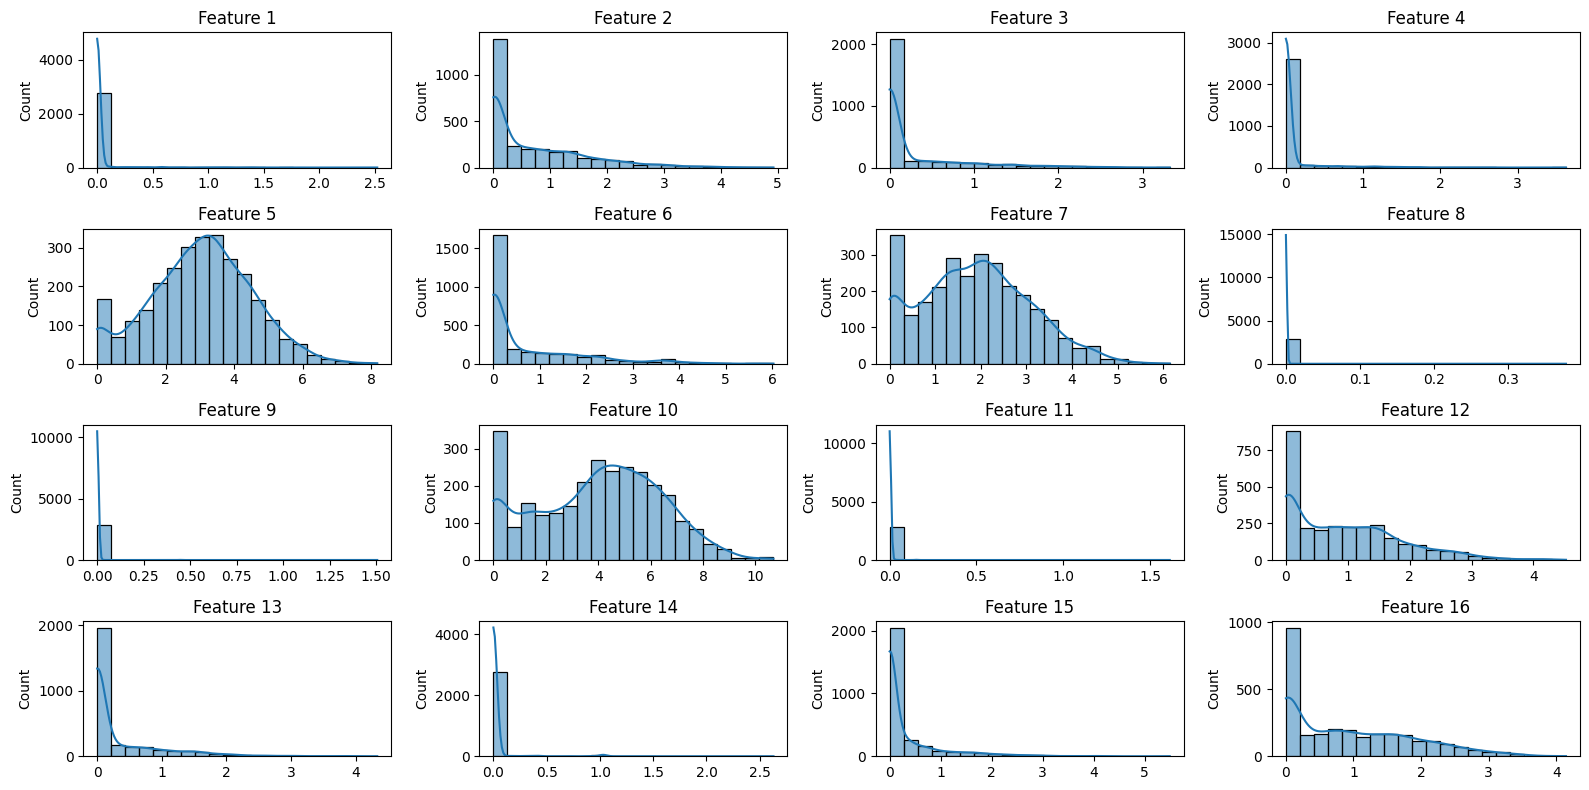

In [11]:
# Save the trained models
import pickle
with open('linear_model.pickle', 'wb') as linear_model_file:
    pickle.dump(linear_model, linear_model_file)

with open('decision_tree_model.pickle', 'wb') as decision_tree_model_file:
    pickle.dump(decision_tree_model, decision_tree_model_file)

with open('random_forest_model.pickle', 'wb') as random_forest_model_file:
    pickle.dump(random_forest_model, random_forest_model_file)

with open('svm_model.pickle', 'wb') as svm_model_file:
    pickle.dump(svm_model, svm_model_file)

# Feature importances for tree-based models (Decision Tree and Random Forest)
def plot_feature_importances(model, feature_names, title="Feature Importances"):
    feature_importances = model.feature_importances_
    sorted_idx = np.argsort(feature_importances)[::-1]
    features = [feature_names[i] for i in sorted_idx]
    importances = feature_importances[sorted_idx]

    plt.figure(figsize=(12, 8))
    plt.bar(range(len(importances)), importances, align="center")
    plt.xticks(range(len(importances)), features, rotation='vertical')
    plt.title(title)
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.show()

# Get feature names from the model
feature_names = [f'feature_{i}' for i in range(X_train_features.shape[1])]

# Plot feature importances for Decision Tree
plot_feature_importances(decision_tree_model, feature_names, title="Decision Tree Feature Importances")

# Plot feature importances for Random Forest
plot_feature_importances(random_forest_model, feature_names, title="Random Forest Feature Importances")

# Visualize predictions on a few samples
num_samples_to_visualize = 10
sample_indices = np.random.choice(range(len(y_test)), num_samples_to_visualize, replace=False)

plt.figure(figsize=(16, 8))
plt.plot(y_test[sample_indices], label="Actual", marker='o')
plt.plot(y_pred_linear[sample_indices], label="Linear Regression", marker='o')
plt.plot(y_pred_decision_tree[sample_indices], label="Decision Tree", marker='o')
plt.plot(y_pred_random_forest[sample_indices], label="Random Forest", marker='o')
plt.plot(y_pred_svm[sample_indices], label="SVM", marker='o')

plt.xlabel("Sample Index")
plt.ylabel("Bone Age")
plt.title("Actual vs Predicted Bone Age on Random Samples")
plt.legend()
plt.show()

# Explore feature distributions
num_features = X_train_features.shape[1]
num_subplot_rows = 4
num_subplot_cols = 4

plt.figure(figsize=(16, 8))
for i in range(min(num_features, num_subplot_rows * num_subplot_cols)):
    plt.subplot(num_subplot_rows, num_subplot_cols, i + 1)
    sns.histplot(X_train_features[:, i], bins=20, kde=True)
    plt.title(f'Feature {i+1}')

plt.tight_layout()
plt.show()


In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Train the model
linear_model = LinearRegression()
linear_model.fit(X_train_features, y_train)

# Predict on the test set
y_pred_linear = linear_model.predict(X_test_features)

# Evaluate the model
mae_linear = mean_absolute_error(y_test, y_pred_linear)
print(f"Mean Absolute Error (Linear Regression) on Test Set: {mae_linear}")

# You can repeat the above steps for other models (Decision Tree, Random Forest, SVM, etc.)

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error

# Train the Decision Tree model
decision_tree_model = DecisionTreeRegressor(random_state=42)
decision_tree_model.fit(X_train_features, y_train)

# Predict on the test set
y_pred_decision_tree = decision_tree_model.predict(X_test_features)

# Evaluate the Decision Tree model
mae_decision_tree = mean_absolute_error(y_test, y_pred_decision_tree)
print(f"Mean Absolute Error (Decision Tree) on Test Set: {mae_decision_tree}")

# Train the Random Forest model
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model.fit(X_train_features, y_train)

# Predict on the test set
y_pred_random_forest = random_forest_model.predict(X_test_features)

# Evaluate the Random Forest model
mae_random_forest = mean_absolute_error(y_test, y_pred_random_forest)
print(f"Mean Absolute Error (Random Forest) on Test Set: {mae_random_forest}")

# Train the SVM model
svm_model = SVR()
svm_model.fit(X_train_features, y_train)

# Predict on the test set
y_pred_svm = svm_model.predict(X_test_features)

# Evaluate the SVM model
mae_svm = mean_absolute_error(y_test, y_pred_svm)
print(f"Mean Absolute Error (SVM) on Test Set: {mae_svm}")


Mean Absolute Error (Linear Regression) on Test Set: 2.508246355030049
Mean Absolute Error (Decision Tree) on Test Set: 1.5532212885154062
Mean Absolute Error (Random Forest) on Test Set: 1.2870588235294116
Mean Absolute Error (SVM) on Test Set: 1.565460819231716


In [13]:
from sklearn.model_selection import KFold, cross_val_score
from numpy import mean, absolute

# Define predictor and response variables
X = X_train_features
y = y_train

# Define different values of k
k_values = [5, 6, 7, 8, 9, 10]

# Models to evaluate
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "SVM": SVR()
}

for model_name, model in models.items():
    print(f"Model: {model_name}")
    for k in k_values:
        # Define cross-validation method
        cv = KFold(n_splits=k, random_state=1, shuffle=True)

        # Fit the model on the training data
        model.fit(X, y)

        # Use k-fold CV to evaluate model
        scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

        # Calculate mean absolute error
        mae = mean(absolute(scores))
        print(f"Mean Absolute Error (k={k}): {mae:.4f}")


Model: Linear Regression


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Mean Absolute Error (k=5): 2.1346
Mean Absolute Error (k=6): 2.1890
Mean Absolute Error (k=7): 2.3276
Mean Absolute Error (k=8): 2.3246
Mean Absolute Error (k=9): 2.3267
Mean Absolute Error (k=10): 2.3558
Model: Decision Tree
Mean Absolute Error (k=5): 1.7447
Mean Absolute Error (k=6): 1.7023
Mean Absolute Error (k=7): 1.6238
Mean Absolute Error (k=8): 1.6333
Mean Absolute Error (k=9): 1.6389
Mean Absolute Error (k=10): 1.6421
Model: Random Forest


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Mean Absolute Error (k=5): 1.3674


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Mean Absolute Error (k=6): 1.3586


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Mean Absolute Error (k=7): 1.3431


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Mean Absolute Error (k=8): 1.3363


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Mean Absolute Error (k=9): 1.3369


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Mean Absolute Error (k=10): 1.3292
Model: SVM


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Mean Absolute Error (k=5): 1.6035
Mean Absolute Error (k=6): 1.5940
Mean Absolute Error (k=7): 1.5848
Mean Absolute Error (k=8): 1.5817
Mean Absolute Error (k=9): 1.5817
Mean Absolute Error (k=10): 1.5785
